# Regression Example

## 0. Import Packages

In this example, we will be using [Keras](https://keras.io/about/) to build a standard [feedforward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) configured for regression. The equivalent scikit-learn model is `sklearn.neural_network.MLPRegressor`. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

## 1. Construct Data

For a supervised learning problem, we are normally given some external data set to train our model. This data may come from a company, research group, or database like [this one](http://archive.ics.uci.edu/ml/index.php). To keep things easy to visualize, we will be making up our own data instead of taking data from an external source. 

Let's try to model a function that takes one feature as an input and returns a scalar as an output. The `target_function` below is an example of a highly non-linear function. You can choose this to be whatever you like, but the more wiggly it is, the more hidden nodes/layers you'll need. Note that the input to an FNN must be a vector, even if it only has one number in it. 

In [3]:
# takes array of length 1 as input, returns scalar output
def target_function(x):
    
    return np.sin(2*x[0]) + np.sin(3*x[0]) + 0.1*x[0]

To make our fake data a little more realistic, let's add a bit of random noise to the target function for each point in the data set X. Each row of X represents an input to the FNN, so the shape of X is (n_train, n_features=1).

In [4]:
# constructs training data from target function with optional noise
def data_generator(X, noise_level=0.0):
    
    n_train = X.shape[0]
    y_train = np.empty(n_train)
    
    for i in range(n_train):
        y_train[i] = target_function(X[i]) + np.random.normal(0, noise_level)
        
    return y_train

We will train our network in the restricted region $[-5,5)$. Later on, we'll see what happens when we test the network in a wider region.

In [5]:
# make training data
X_train = np.random.uniform(-5, 5, (5000, 1))
y_train = data_generator(X_train, noise_level=0.1)

Here is what the true target function looks like with the simulated data:

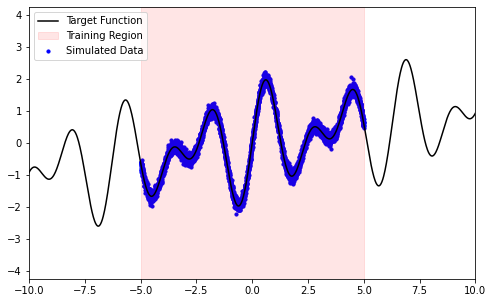

In [6]:
# plot true target function in wider domain
X_true = np.linspace(-20, 20, num=2000).reshape(2000,1)
y_true = data_generator(X_true, noise_level=0.0)

plt.figure(figsize=(8,5))
plt.plot(X_true.flatten(), y_true, color='k', label='Target Function')
plt.scatter(X_train.flatten(), y_train, color='b', s=10, label='Simulated Data')
plt.axvspan(-5, 5, alpha=0.1, color='r', label='Training Region')
plt.xlim(-10, 10)
plt.legend()

## 2. Build Neural Network Interpolator

We will build our network using Keras again. There are a few differences compared to the binary classification example:

1. We need to start with a lot more hidden units because our target function is so wiggly.
2. There is no output layer activation function (i.e. it's linear).
3. The loss function is mean squared error.

In [7]:
# seed here for reproducible results, you can remove this
np.random.seed(1)

# build Keras Sequential model
model = Sequential()
model.add(Dense(200, input_dim=1, activation='relu', name='hidden1'))
model.add(Dense(100, activation='relu', name='hidden2'))
model.add(Dense(1, activation="linear", name='output'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 200)               400       
_________________________________________________________________
hidden2 (Dense)              (None, 100)               20100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


## 3. Train Neural Network Interpolator

Train the network.

In [8]:
training = model.fit(X_train, y_train, epochs=300, validation_split=0.2, shuffle=True, verbose=0)
print(training.history.keys())

dict_keys(['val_loss', 'val_mse', 'loss', 'mse'])


Plot the training and validation losses as a function of training epoch.

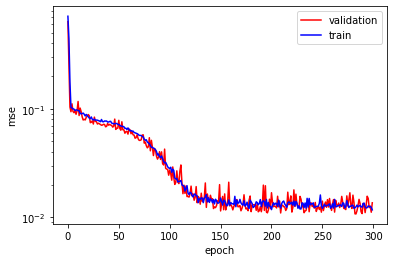

In [9]:
plt.semilogy(training.history['val_mse'], color='r', label='validation')
plt.semilogy(training.history['mse'], color='b', label='train')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

Do you notice the regions where the mean squared error plateaus for a while? Rerun the above code with fewer training epochs and see if you can figure out why this happens.

Plot the prediction of the model over a wider region. What happens to the prediction outside the training region?

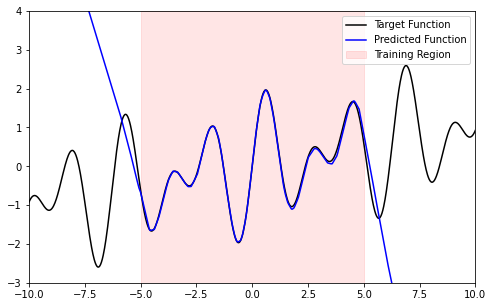

In [10]:
y_pred = model.predict(X_true)

plt.figure(figsize=(8,5))
plt.plot(X_true.flatten(), y_true, color='k', label='Target Function')
plt.plot(X_true.flatten(), y_pred, color='b', label='Predicted Function')
plt.axvspan(-5, 5, alpha=0.1, color='r', label='Training Region')
plt.xlim(-10, 10)
plt.ylim(-3, 4)
plt.legend()

## 4. Format Data For Extrapolation

From the previous plot, it is clear that the neural network above completely fails to learn anything outside of the training region. If you only ever saw the training data in the red region, would you have been able to guess that the wiggly pattern repeats?

Let's explore a different way you can perform regression while maintaining more accuracy beyond the training region. To do this, we need to gather and format our data in a completely different way (Julie talked about this sequential formatting last week).

First, the inputs to our target function need to be evenly spaced. The spacing can't be too small, otherwise the differences in $y$ will be too small to work with.

In [11]:
X = np.linspace(-5, 5, num=200).reshape(200,1)
y = data_generator(X, noise_level=0.0)

Next, we construct sequentially formatted data using the target labels only:

In [12]:
seq = 10

def sequential_format(y):
    
    n = y.shape[0]-1-seq
    X_train = np.zeros((n, seq))
    y_train = np.zeros(n)
    
    for i in range(n):
        
        X_train[i] = y[i:i+seq]
        y_train[i] = y[i+seq]
        
    return X_train, y_train

X_train_seq, y_train_seq = sequential_format(y)

## 4. Build Neural Network Extrapolator

Instead of training our network to take a value $x$ and return $y(x)$, we are training our network to take a series of values $y(x), y(x+\Delta x), ... , y(x+(seq-1)\Delta x)$ and return the next value $y(x+seq\cdot\Delta x)$. So we need `seq` inputs, but everything remains very similar to before. 

In [13]:
# seed here for reproducible results, you can remove this
np.random.seed(1)

# build Keras Sequential model
model = Sequential()
model.add(Dense(20, input_dim=seq, activation='relu', name='hidden1'))
model.add(Dense(10, activation='relu', name='hidden2'))
model.add(Dense(1, activation="linear", name='output'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 20)                220       
_________________________________________________________________
hidden2 (Dense)              (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________


## 5. Train Neural Network Extrapolator

Train the network with the sequentially formatted data.

In [14]:
training = model.fit(X_train_seq, y_train_seq, epochs=1000, validation_split=0.1, shuffle=True, verbose=0)

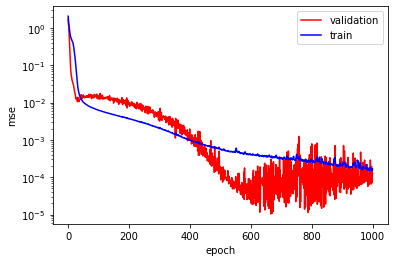

In [15]:
plt.semilogy(training.history['val_mse'], color='r', label='validation')
plt.semilogy(training.history['mse'], color='b', label='train')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

To be a true extrapolator, predictions outside of the training region should be built upon predictions inside the training region only.

In [16]:
def extrapolate(model, X_train_seq, iterations=1000):
    
    # predict beyond training region using previous predictions
    n = X_train_seq.shape[0]
    y_pred = np.empty(n+iterations)
    y_pred[:n] = model.predict(X_train_seq).flatten()
    
    for i in range(n, n+iterations):
        
        X_seq = [[y_pred[i-seq+j] for j in range(seq)]]
        y_pred[i] = model.predict(np.array(X_seq))
        
    return y_pred


To plot the extrapolation, we also have to find the corresponding input values.

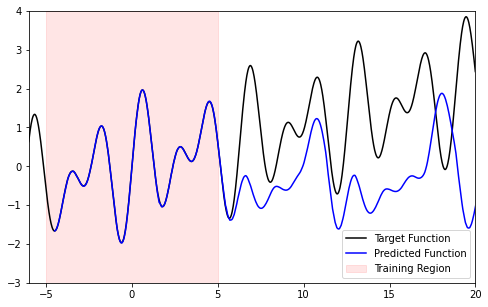

In [17]:
y_pred = extrapolate(model, X_train_seq, iterations=5000)

dX = X[1]-X[0]
X_pred = np.array([-5+(i+seq)*dX for i in range(y_pred.shape[0])])


plt.figure(figsize=(8,5))
plt.plot(X_true.flatten(), y_true, color='k', label='Target Function')
plt.plot(X_pred, y_pred, color='b', label='Predicted Function')
plt.axvspan(-5, 5, alpha=0.1, color='r', label='Training Region')
plt.xlim(-6, 20)
plt.ylim(-3, 4)
plt.legend()


The extrapolator seems to pick up on the periodicity in the data, but the extrapolation is still off. Play around with the network structure, activation function, number of epochs, and number of features `seq`. Can you find a set of parameters that captures the periodicity *and* the slight upward trend?